# Data sources

## Read pre-trained dictionary file

In [12]:
import csv
import numpy as np
# import emoji
import pandas as pd

def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)
        
        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map

## Read input data file (format csv, colume 1: sentence, colume 2: label)

In [13]:
def read_csv(filename):
    phrase = []
    emoji = []

    with open (filename) as csvDataFile:
        csvReader = csv.reader(csvDataFile)

        for row in csvReader:
            phrase.append(row[0])
            emoji.append(row[1])

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

In [14]:
import re
def read_corpus(filename):
    phrase = []
    emoji = []

    with open (filename, encoding='latin-1') as csvDataFile:
        csvReader = csv.reader(csvDataFile)
        next(csvReader, None)  # skip the headers
        try:    
            for row in csvReader:
                phrase.append(' '.join(re.findall(r"[\w']+", row[0])))
                emoji.append(0 if row[1].strip() == '__label__1' else 1)
        except Exception as a:
            pass

    X = np.asarray(phrase)
    Y = np.asarray(emoji, dtype=int)

    return X, Y

## One-hot encoding label

In [15]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)]
    return Y

## Encode sentence to indices of word

In [17]:
def sentences_to_indices(X, word_to_index, max_len):
    """
    Converts an array of sentences (strings) into an array of indices corresponding to words in the sentences.
    The output shape should be such that it can be given to `Embedding()`

    Arguments:
    X -- array of sentences (strings), of shape (m, 1)
    word_to_index -- a dictionary containing the each word mapped to its index
    max_len -- maximum number of words in a sentence. You can assume every sentence in X is no longer than this.

    Returns:
    X_indices -- array of indices corresponding to words in the sentences from X, of shape (m, max_len)
    """

    m = X.shape[0]  # number of training examples
    # Initialize X_indices as a numpy matrix of zeros and the correct shape (≈ 1 line)
    X_indices = np.zeros((m, max_len))

    for i in range(m):  # loop over training examples
        # Convert the ith training sentence in lower case and split is into words. You should get a list of words.
        sentence_words = (X[i].lower()).split()
        # Initialize j to 0
        j = 0
        # Loop over the words of sentence_words
        for w in sentence_words:
            # Set the (i,j)th entry of X_indices to the index of the correct word.
            if w in word_to_index:
                X_indices[i, j] = word_to_index[w]
                # Increment j to j + 1
                j = j + 1
    return X_indices

## Preprocess data, encode input data and labels

In [18]:
def preprocess_data(X, Y, C, word_to_index, max_len):
    # Convert each sentence to array of index in dictionary
    X_indices = sentences_to_indices(X, word_to_index, max_len)

    # Converts label to OneHot vector with len = C
    Y_oh = convert_to_one_hot(Y, C=C)
    return X_indices, Y_oh


def label_to_emoji(label):
    """
    Converts a label (int or string) into the corresponding emoji code (string) ready to be printed
    """
    emoji_dictionary = {"1": "\u2764\uFE0F",    # :heart: prints a black instead of red heart depending on the font
                        "0": ":disappointed:"}
    return emoji.emojize(emoji_dictionary[str(label)], use_aliases=True)
              

## Embedding layer

In [19]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
import numpy as np
from keras.layers.embeddings import Embedding

def pretrained_embedding_layer(word_to_vec_map, word_to_index):
    """
    Creates a Keras Embedding() layer and loads in pre-trained GloVe 50-dimensional vectors.

    Arguments:
    word_to_vec_map -- dictionary mapping words to their GloVe vector representation.
    word_to_index -- dictionary mapping from words to their indices in the vocabulary (400,001 words)

    Returns:
    embedding_layer -- pretrained layer Keras instance
    """
    vocab_len = len(word_to_index) + 1  # adding 1 to fit Keras embedding (requirement)
    emb_dim = word_to_vec_map["cucumber"].shape[0]  # define dimensionality of your GloVe word vectors (= 50)

    # Initialize the embedding matrix as a numpy array of zeros of shape (vocab_len, dimensions of word vectors = emb_dim)
    emb_matrix = np.zeros((vocab_len, emb_dim))

    # Set each row "index" of the embedding matrix to be the word vector representation of the "index"th word of the vocabulary
    for word, index in word_to_index.items():
        emb_matrix[index, :] = word_to_vec_map[word]

    # Define Keras embedding layer with the correct output/input sizes, make it trainable. Use Embedding(...). Make sure to set trainable=False.
    embedding_layer = Embedding(vocab_len, emb_dim)

    # Build the embedding layer, it is required before setting the weights of the embedding layer. Do not modify the "None".
    embedding_layer.build((None,))

    # Set the weights of the embedding layer to the embedding matrix. Your layer is now pretrained.
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

## Model

In [20]:
import numpy as np
from keras.models import Model
from keras.layers import Dense, Input, Dropout, LSTM, Activation, LeakyReLU, Bidirectional, SimpleRNN, GRU
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.initializers import glorot_uniform
from keras.callbacks import ModelCheckpoint, Callback
from keras import optimizers
import datetime


def SentimentAnalysis(input_shape, classes_nb, embedding_layer, summary=False):
    # Define sentence_indices as the input of the graph, it should be of shape input_shape and dtype 'int32' (as it contains indices).
    sentence_indices = Input(shape=input_shape, dtype=np.int32)

    
    embeddings = embedding_layer(sentence_indices)
    
    # X = Bidirectional(LSTM(128, return_sequences=True))(embeddings)
    X = LSTM(128, return_sequences=True)(embeddings)
#     X = SimpleRNN(128, return_sequences=True)(embeddings)
#     X = GRU(128, return_sequences=True)(embeddings)
    X = Dropout(0.5)(X)

    # X = LSTM(128, return_sequences=True)(X)
    # X = Dropout(0.1)(X)
    # X = Bidirectional(LSTM(128))(X)
    X = LSTM(128)(X)
#     X = SimpleRNN(128)(X)
#     X = GRU(128)(X)
    
    X = Dropout(0.5)(X)
    # X = Dense(256)(X)
    # X = LeakyReLU(alpha=0.15)(X)
    # X = Dropout(0.5)(X)
    # X = Dense(32)(X)
    # X = LeakyReLU(alpha=0.15)(X)
    
    X = Dense(classes_nb)(X)
    # Add a softmax activation
    X = Activation('softmax')(X)

    # Create Model instance which converts sentence_indices into X.
    model = Model(sentence_indices, X)

    # Show summary of model
    if summary: model.summary()
    opt = optimizers.Adam(lr=0.0002)
    # Compiple model
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

    return model


class TrainingHistory(Callback):
  def __init__(self, net):
    self.net = net
  
  def on_train_begin(self, logs={}):
    self.histories = []

  def on_epoch_end(self, epoch, logs={}):
    # print(logs)
    print("\repoch:", epoch, end='')
    self.histories.append([logs.get('loss'), 
                           logs.get('accuracy', logs.get('acc', 0)), 
                           logs.get('val_loss'), 
                           logs.get('val_accuracy', logs.get('val_acc', 0))])
    np.savetxt("./model/"+self.net+"-history.txt", self.histories, delimiter=",")


def today():
  return '{:02d}{:02d}'.format(datetime.date.today().month, datetime.date.today().day)

def get_callbacks(net_name):
    # checkpoint
    filepath="./model/"+net_name+"-"+ today() +"-weights-{epoch:02d}-{loss:.2f}-{acc:.2f}-{val_loss:.2f}-{val_acc:.2f}.hdf5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    log_history = TrainingHistory(net_name)
    _callbacks = [checkpoint, log_history]
    # _callbacks = [log_history]
    return _callbacks


In [10]:
import warnings
warnings.filterwarnings('ignore',category=Warning)
import sys
import numpy as np
from sklearn.model_selection import train_test_split
# from data_sources import *    
# from visualization import *
# from embedding import *
from model import *
np.random.seed(1)

## Load dictionary and input data

In [21]:
# Read train and test files
print("Loading raw data")
# X, Y = read_csv('imdb_labelled.txt.csv')
X, Y = read_corpus('corpus.csv')
print("Data size", len(Y))
print("Label 0: ", len(list(filter(lambda x: x == 0, Y))))
# Read 50 feature dimension glove file
print("Loading dictionary file.")
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('glove.6B.50d.txt')

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
objects = ('Negative', 'Positive')
y_pos = np.arange(len(objects))
ng = len(list(filter(lambda x: x == 0, Y)))
po = len(list(filter(lambda x: x == 1, Y)))
y = [ng,po]

plt.bar(y_pos, y, align='center', alpha=0.5)
for i, v in enumerate(y):
  plt.text(i, v+100, str(v), color='red', va='center', fontweight='bold')
plt.xticks(y_pos, objects)
plt.ylabel('samples')
plt.title('Numbers of samples')

plt.show()

Loading raw data
Data size 10000
Label 0:  5097
Loading dictionary file.


<Figure size 640x480 with 1 Axes>

## preprocess data and split train/test set

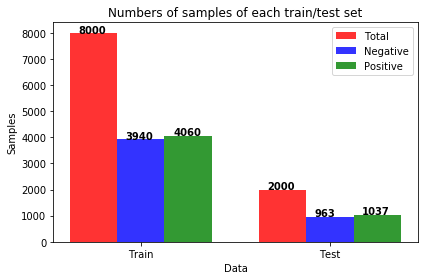

In [24]:
CLASSES_NUMBER = 2
# Compute max length of sentences set
maxLen = len(max(X, key= lambda x : len(x.split())).split())
# Preprocess input data
X1, Y1 = preprocess_data(X, Y, CLASSES_NUMBER, word_to_index, maxLen)

# Split train/test set
X_train, X_test, Y_train, Y_test = train_test_split(X1, Y1, test_size=0.2, random_state=42)

import numpy as np
import matplotlib.pyplot as plt

# data to plot
n_groups = 2
_ne_ = (len(list(filter(lambda x: all(x == [0, 1]), Y_train))), 
        len(list(filter(lambda x: all(x == [0, 1]), Y_test))))
_po_ = (len(list(filter(lambda x: all(x == [1, 0]), Y_train))), 
        len(list(filter(lambda x: all(x == [1, 0]), Y_test))))
total = (len(Y_train), len(Y_test))

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.25
opacity = 0.8

rects1 = plt.bar(index, total, bar_width,
alpha=opacity,
color='r',
label='Total')

rects1 = plt.bar(index + bar_width, _ne_, bar_width,
alpha=opacity,
color='b',
label='Negative')

rects2 = plt.bar(index + 2*bar_width, _po_, bar_width,
alpha=opacity,
color='g',
label='Positive')

plt.xlabel('Data')
plt.ylabel('Samples')
plt.title('Numbers of samples of each train/test set')
plt.xticks(index + bar_width, ('Train', 'Test'))
plt.legend()

for i, v in enumerate(total):
  plt.text(i-0.08, v+120, str(v), color='black', va='center', fontweight='bold')

for i, v in enumerate(_ne_):
  plt.text(i+bar_width-0.08, v+120, str(v), color='black', va='center', fontweight='bold')

for i, v in enumerate(_po_):
  plt.text(i+2*bar_width-0.08, v+120, str(v), color='black', va='center', fontweight='bold')  

plt.tight_layout()
plt.show()

## Build model

In [15]:
# Create the embedding layer pretrained with GloVe Vectors (≈1 line)
embedding_layer = pretrained_embedding_layer(word_to_vec_map, word_to_index)
embedding_layer.trainable=False
# Model and model summmary
model = SentimentAnalysis((maxLen,), CLASSES_NUMBER, embedding_layer, summary=True)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 215)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 215, 50)           20000050  
_________________________________________________________________
lstm_1 (LSTM)                (None, 215, 128)          91648     
_________________________________________________________________
dropout_1 (Dropout)          (None, 215, 128)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 258 

# Embedder

In [33]:
def Embedder(input_shape, embedding_layer):
    sentence_indices = Input(shape=input_shape, dtype=np.int32)
    
    embeddings       = embedding_layer(sentence_indices)
    
    model            = Model(sentence_indices, embeddings)
    return model

raw_s = "I love this book"
input_s = sentences_to_indices(np.asarray([raw_s]), word_to_index, 10)
print("Input shape:", input_s.shape[1:])
print("Indiced sentence:", input_s)
embedder = Embedder((10,), embedding_layer)
embedded_s = embedder.predict([input_s])
print("Embedding shape:", embedded_s.shape[1:])
print("Embedded:", embedded_s)

Input shape: (10,)
Indiced sentence: [[185457. 226278. 358160.  80586.      0.      0.      0.      0.      0.
       0.]]
Embedding shape: (10, 50)
Embedded: [[[ 1.1891e-01  1.5255e-01 -8.2073e-02 -7.4144e-01  7.5917e-01
   -4.8328e-01 -3.1009e-01  5.1476e-01 -9.8708e-01  6.1757e-04
   -1.5043e-01  8.3770e-01 -1.0797e+00 -5.1460e-01  1.3188e+00
    6.2007e-01  1.3779e-01  4.7108e-01 -7.2874e-02 -7.2675e-01
   -7.4116e-01  7.5263e-01  8.8180e-01  2.9561e-01  1.3548e+00
   -2.5701e+00 -1.3523e+00  4.5880e-01  1.0068e+00 -1.1856e+00
    3.4737e+00  7.7898e-01 -7.2929e-01  2.5102e-01 -2.6156e-01
   -3.4684e-01  5.5841e-01  7.5098e-01  4.9830e-01 -2.6823e-01
   -2.7443e-03 -1.8298e-02 -2.8096e-01  5.5318e-01  3.7706e-02
    1.8555e-01 -1.5025e-01 -5.7512e-01 -2.6671e-01  9.2121e-01]
  [-1.3886e-01  1.1401e+00 -8.5212e-01 -2.9212e-01  7.5534e-01
    8.2762e-01 -3.1810e-01  7.2204e-03 -3.4762e-01  1.0731e+00
   -2.4665e-01  9.7765e-01 -5.5835e-01 -9.0318e-02  8.3182e-01
   -3.3317e-01  2.264

# SVM model

In [0]:
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
# Create feature vectors
vectorizer = TfidfVectorizer(min_df = 5,
                             max_df = 0.8,
                             sublinear_tf = True,
                             use_idf = True)
X2 = [x.lower() for x in X]
d_train, d_test, l_train, l_test = train_test_split(X2, Y, test_size=0.2, random_state=42)
train_vectors = vectorizer.fit_transform(d_train.copy())
test_vectors = vectorizer.transform(d_test)


clf = SVC(C=10**4, gamma='auto',verbose=True, max_iter=100,random_state=2)
clf.fit(train_vectors, l_train)
prediction = clf.predict(test_vectors)
classification_report(l_test, prediction , output_dict=True)
# classification_report(l_train,  clf.predict(train_vectors) , output_dict=True)
# print(sum(clf.predict(X_test) == (np.argmax(Y_test, axis=1))) / len(Y_test))
# print(sum(clf.predict(X_train) == (np.argmax(Y_train, axis=1))) / len(Y_train))

[LibSVM]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:241: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


{'0': {'f1-score': 0.7233830845771144,
  'precision': 0.7471736896197327,
  'recall': 0.7010607521697203,
  'support': 1037},
 '1': {'f1-score': 0.7206030150753769,
  'precision': 0.6981499513145083,
  'recall': 0.7445482866043613,
  'support': 963},
 'accuracy': 0.722,
 'macro avg': {'f1-score': 0.7219930498262457,
  'precision': 0.7226618204671205,
  'recall': 0.7228045193870408,
  'support': 2000},
 'weighted avg': {'f1-score': 0.7220444811120278,
  'precision': 0.7235687596257672,
  'recall': 0.722,
  'support': 2000}}

## Train model

Train model in iter 0
Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 215)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 215, 50)           20000050  
_________________________________________________________________
lstm_11 (LSTM)               (None, 215, 128)          91648     
_________________________________________________________________
dropout_11 (Dropout)         (None, 215, 128)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 2

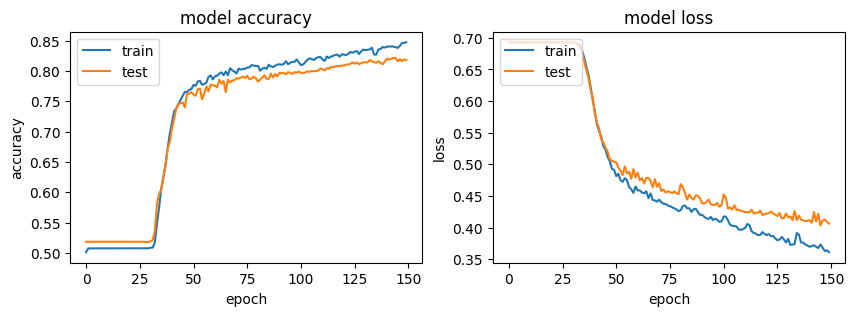

In [28]:
epochs = 150
NET_NAME = 'lstm'
for try_count in range(1):
    print("Train model in iter {}".format(try_count))
    model = SentimentAnalysis((maxLen,), CLASSES_NUMBER, embedding_layer, summary=True)
    net_name = NET_NAME + '-' + str(try_count) + '-' + str(epochs)
    model.fit(X_train, Y_train, 
              epochs=epochs, 
              batch_size=2000, 
              workers=4,
              verbose=1,
              shuffle=True,
              use_multiprocessing=True,
              validation_data=(X_test, Y_test), 
              callbacks=get_callbacks(net_name))

    # Visualize History of Traing model
    show_training_history("./model/"+net_name+"-history.txt")
    # Evaluate model, loss and accuracy
    # loss, acc = model.evaluate(X_test, Y_test, verbose=1)
    # print()
    # print("Test accuracy = ", acc)

## Evaluate model

In [22]:
from keras.models import load_model
from keras.models import Model

model_path = 'model/lstm-0-150-1216-weights-144-0.37-0.84-0.41-0.82.hdf5'
print("Loading weights from", model_path)
predictor = load_model(model_path)
inp = predictor.input                                          
outputs = [predictor.layers[-2].output]          
linear_predictor = Model(inp, outputs)

Loading weights from model/lstm-0-150-1216-weights-144-0.37-0.84-0.41-0.82.hdf5


In [25]:
import numpy as np
# Evaluate model, loss and accuracy
# loss, acc = model.evaluate(X, Y, verbose=1)
# print()
# print("Test accuracy = ", acc)

sentence = "I love this book so much"
# sentence = "I hate this book"
# sentence = "this book is so funny"
# sentence = "Someone think this book is so funny, but i don't think so"
print("Sentence:", sentence)


encoded_s = sentences_to_indices(np.asarray([sentence]), word_to_index, maxLen)
print("Sentences to indices:", encoded_s)
print ("Softmax input:", linear_predictor.predict(encoded_s)[0])
softmax_out = predictor.predict(encoded_s)[0]
print("Softmax output:", softmax_out)
y_pred = np.argmax(softmax_out)
print("This is {} commnent.".format('positive' if y_pred else 'negative'))

Sentence: I love this book so much
Sentences to indices: [[185457. 226278. 358160.  80586. 336114. 251645.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      0.      0.      0.
       0.      0.      0.      0.      0.      0.      

## Visualize Training history

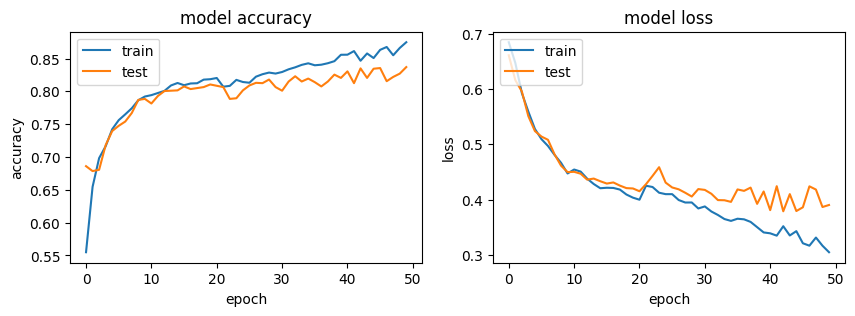

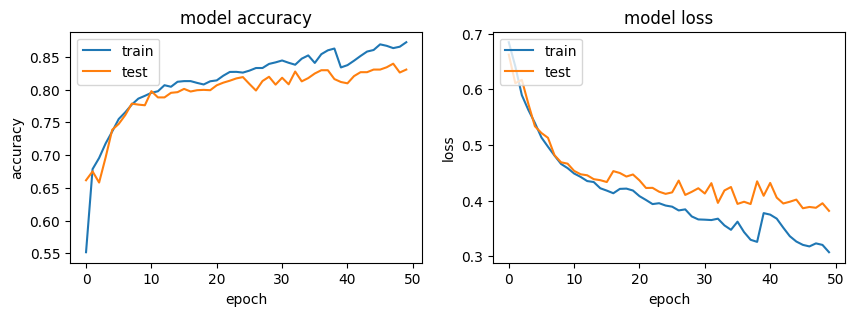

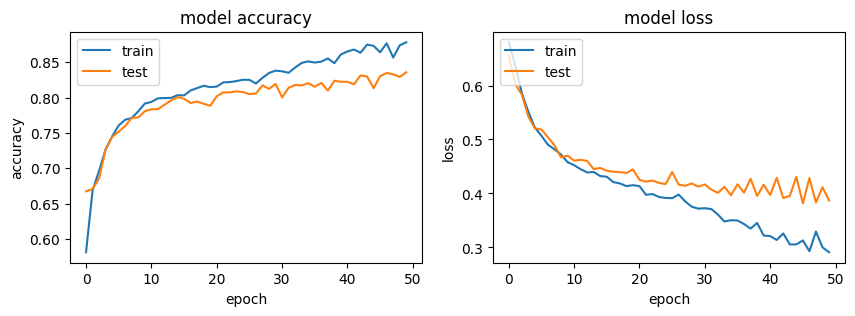

In [18]:
import numpy as np
from matplotlib import pyplot as plt 

def show_training_history(file_path):
    histories=np.loadtxt(file_path, delimiter=",")
    f = plt.figure(figsize=(10,3))

    f.add_subplot(1,2, 1)
    plt.plot(histories[:, 1])
    plt.plot(histories[:, 3])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.show()

    # summarize history for loss
    f.add_subplot(1,2, 2)
    plt.plot(histories[:, 0])
    plt.plot(histories[:, 2])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
show_training_history("./model/bi-direct-1-50-history.txt")
print()
show_training_history("./model/bi-direct-3-50-history.txt")
print()
show_training_history("./model/bi-direct-5-50-history.txt")